In [ ]:
PART 1:

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve

In [11]:
#load data
logins = pd.read_json(r"C:\Users\eshab\Downloads\logins.json")

#There are timestamps of user logins in a particular
# geographic location.
logins['login_time'] = pd.to_datetime(logins['login_time'])
logins.set_index('login_time', inplace=True)

# Aggregate these login counts based on 15 minute time intervals, and
# visualize and describe the resulting time series of login counts in ways that best characterize the
# underlying patterns of the demand.
# Add a dummy column to count
logins['count'] = 1
logins_15min = logins['count'].resample('15min').sum()

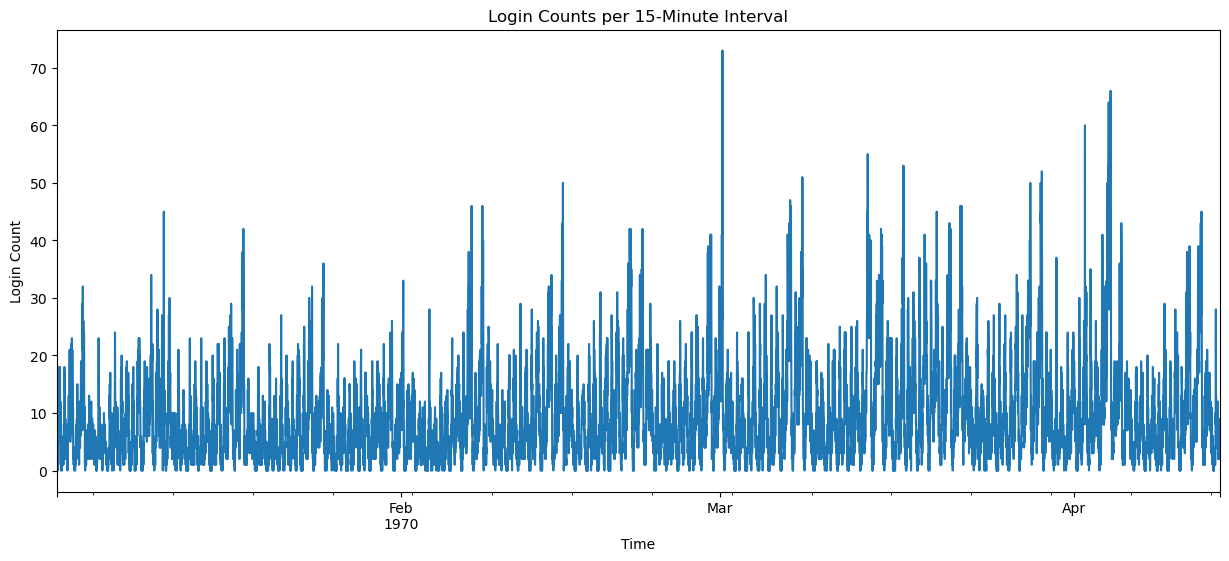

In [13]:
# Plot time series
plt.figure(figsize=(15, 6))
logins_15min.plot()
plt.title('Login Counts per 15-Minute Interval')
plt.xlabel('Time')
plt.ylabel('Login Count')
plt.show()

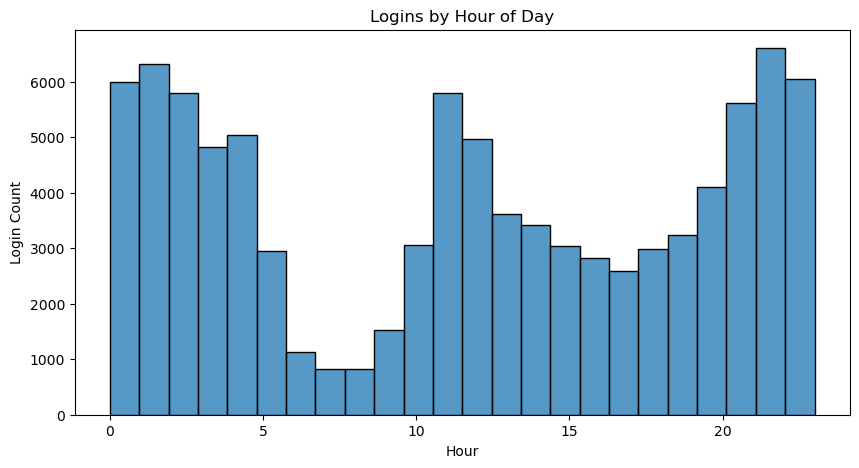

In [15]:
# Daily/Hourly Trends
logins['hour'] = logins.index.hour
logins['weekday'] = logins.index.weekday

# Hourly histogram
plt.figure(figsize=(10, 5))
sns.histplot(logins['hour'], bins=24, kde=False)
plt.title('Logins by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Login Count')
plt.show()

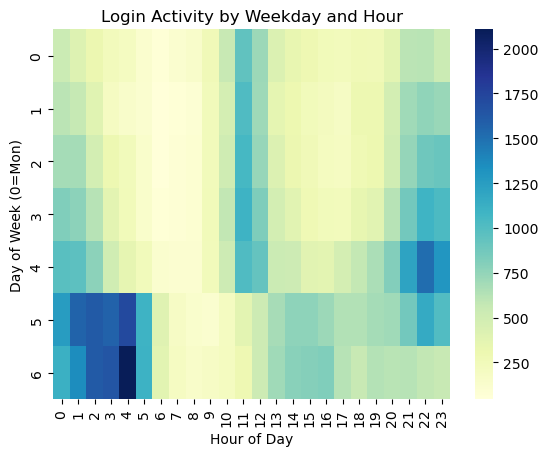

In [17]:
# Weekday heatmap
heatmap_data = logins.groupby(['weekday', 'hour']).size().unstack()
sns.heatmap(heatmap_data, cmap="YlGnBu")
plt.title('Login Activity by Weekday and Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week (0=Mon)')
plt.show()

In [ ]:
PART 2:

In [ ]:
The primary mertric would be measuring the Proportion of driver partners who complete trips in both Gotham and Metropolis during a week,
since it directly reflects the desired cross-city driving behavior.

This can be tracked from trip logs: compare driver_id + city_id combinations and a binary outcome 
(did the driver serve both cities or not), which simplifies evaluation.

Better than raw trip count because it isolates mobility behavior, not just usage volume.

2) Experiment Design

a) Implementation (Experimental Setup)
Design: A/B Test (Randomized Controlled Trial)
Treatment Group: Drivers offered toll reimbursement for cross-city trips.

Control Group: Drivers not offered the reimbursement (status quo).

Assignment:
Randomly assign eligible drivers across both cities to either group.

Ensure randomization is stratified by baseline activity (e.g., night/day, weekend/weekday drivers) to reduce confounding.

Duration:
Run the test for at least 2–4 weeks, covering multiple weekdays and weekends to capture circadian rhythms.

b) Statistical Test(s)
    1. Primary Analysis:
Use a two-proportion z-test to compare:

% of drivers in treatment group who served both cities vs. % in control group

    2. Secondary Analyses:
Use logistic regression to control for covariates:

Baseline driving activity, City of origin, Day of the week


Caveats to Highlight:
- Behavior may revert once reimbursement ends (test for post-treatment persistence)
- External events (weather, events, strikes) may influence activity during test window
- Ensure fairness: long-term drivers might feel penalized if not offered the incentive


In [ ]:
PART 3:

In [23]:
df = pd.read_json(r"C:\Users\eshab\Downloads\ultimate_data_challenge.json")

# Convert date columns
df['signup_date'] = pd.to_datetime(df['signup_date'])
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])

# Define retention (active in the last 30 days (after May 31, 2014))
df['retained'] = df['last_trip_date'] >= pd.to_datetime('2014-06-01')

# fill missing values
df['avg_rating_by_driver'].fillna(df['avg_rating_by_driver'].mean(), inplace=True)
df['avg_rating_of_driver'].fillna(df['avg_rating_of_driver'].mean(), inplace=True)


C:\Users\eshab\AppData\Local\Temp\ipykernel_18808\3396833376.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['avg_rating_by_driver'].fillna(df['avg_rating_by_driver'].mean(), inplace=True)
C:\Users\eshab\AppData\Local\Temp\ipykernel_18808\3396833376.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting value

In [25]:
# Encode categorical variables
df_encoded = pd.get_dummies(df, columns=['city', 'phone'], drop_first=True)

# Define features and target
X = df_encoded.drop(columns=['last_trip_date', 'signup_date', 'retained'])
y = df_encoded['retained']

# Split and train model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predictions and evaluation
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]

# Print evaluation metrics
print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))

Classification Report:
               precision    recall  f1-score   support

       False       0.80      0.81      0.80      9379
        True       0.67      0.66      0.66      5621

    accuracy                           0.75     15000
   macro avg       0.73      0.73      0.73     15000
weighted avg       0.75      0.75      0.75     15000

ROC AUC Score: 0.8158144904607053


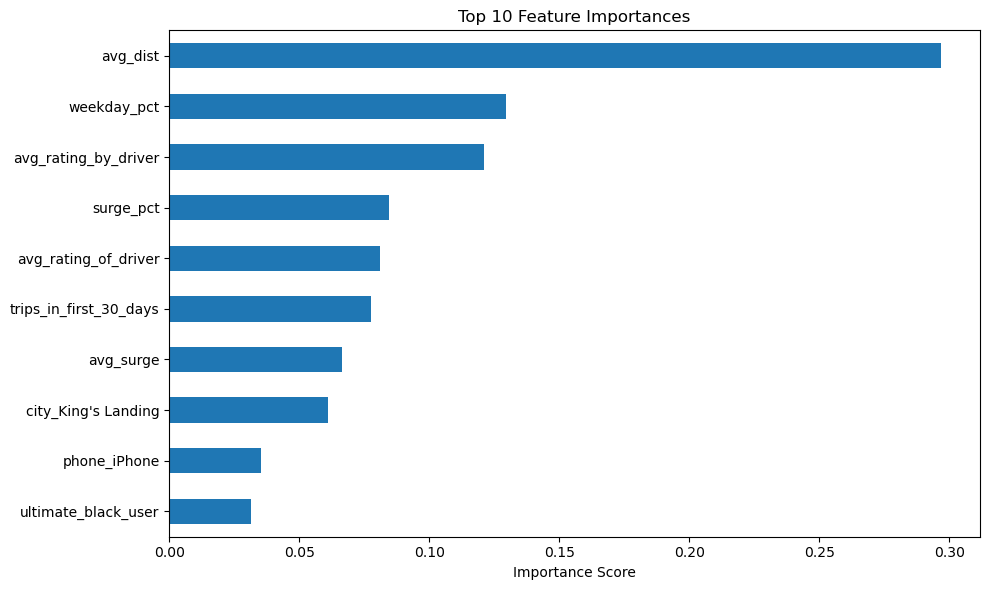

In [27]:
# Plot feature importances
importances = pd.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
importances[:10].plot(kind='barh')
plt.title('Top 10 Feature Importances')
plt.xlabel('Importance Score')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

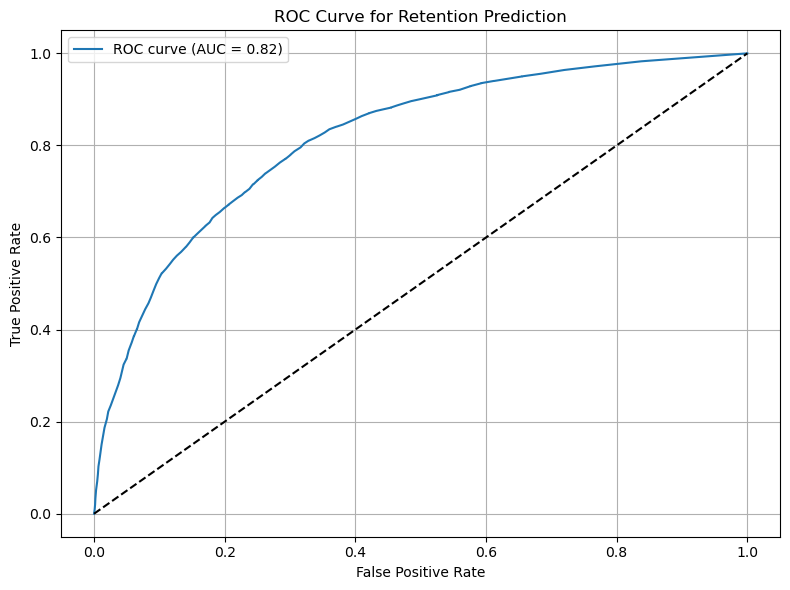

In [29]:
# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc_score(y_test, y_proba):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve for Retention Prediction')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()